# Titanic EDA Notebook

This notebook is dedicated to exploratory data analysis (EDA) on the Titanic dataset.  
Note: Preprocessing functions (scaling, encoding, etc.) are defined in `data_processing.py` and `processed.py`.  
Here we mainly focus on data exploration, visualization, and feature understanding.


In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


# add project root to sys.path so imports work
sys.path.append(os.path.abspath(".."))

#import functions
from src.data_preprocessing import clean_data, feature_engineering, splitting_data

# (Optional) stats tests
from statsmodels.tsa.stattools import adfuller

In [2]:
# ================================
# 2. Load Raw Data
# ================================
df = pd.read_excel("../data/raw.xlsx")  # adjust path if needed
df.head()
print("Shape of dataset:", df.shape)
df.info()
df.describe()
df.isnull().sum()

print("df columns: ",df.columns)

Shape of dataset: (501, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          501 non-null    datetime64[ns]
 1   Open          501 non-null    float64       
 2   High          501 non-null    float64       
 3   Low           501 non-null    float64       
 4   Close         501 non-null    float64       
 5   Volume        501 non-null    int64         
 6   Dividends     501 non-null    float64       
 7   Stock Splits  501 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 31.4 KB
df columns:  Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits'],
      dtype='object')


In [3]:
# ================================
# 3. Data Cleaning & Exploration
# ================================
df = clean_data(df)


#print("df columns: ",df.columns)
# Missing values
print("Missing values per column:")
print(df.isnull().sum())

# Check duplicates
print("Duplicates:", df.duplicated().sum())


print("df columns: ",df.columns)

Missing values per column:
Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64
Duplicates: 0
df columns:  Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits'],
      dtype='object')


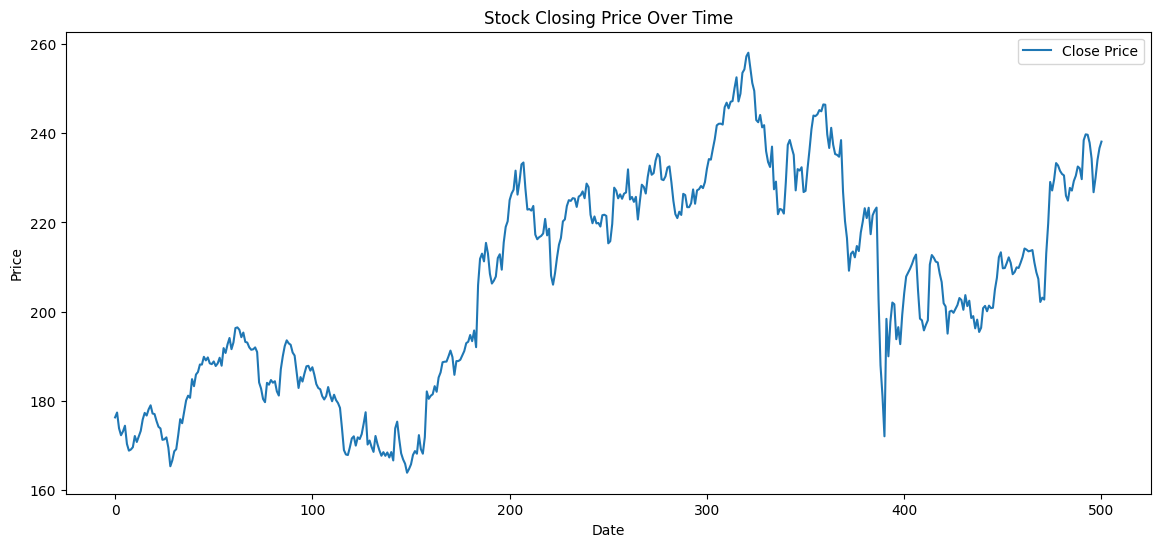

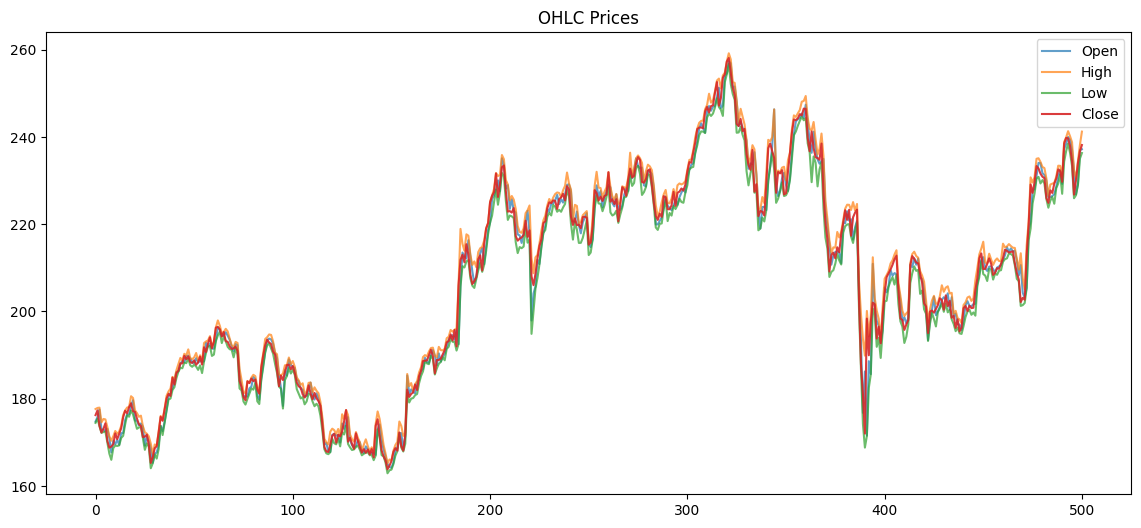

In [4]:
# ================================
# 4. Visualize OHLC Data
# ================================
plt.figure(figsize=(14,6))
plt.plot(df.index, df['Close'], label="Close Price")
plt.title("Stock Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# Candlestick-like OHLC exploration (optional)
plt.figure(figsize=(14,6))
plt.plot(df['Open'], label='Open', alpha=0.7)
plt.plot(df['High'], label='High', alpha=0.7)
plt.plot(df['Low'], label='Low', alpha=0.7)
plt.plot(df['Close'], label='Close', alpha=0.9)
plt.title("OHLC Prices")
plt.legend()
plt.show()



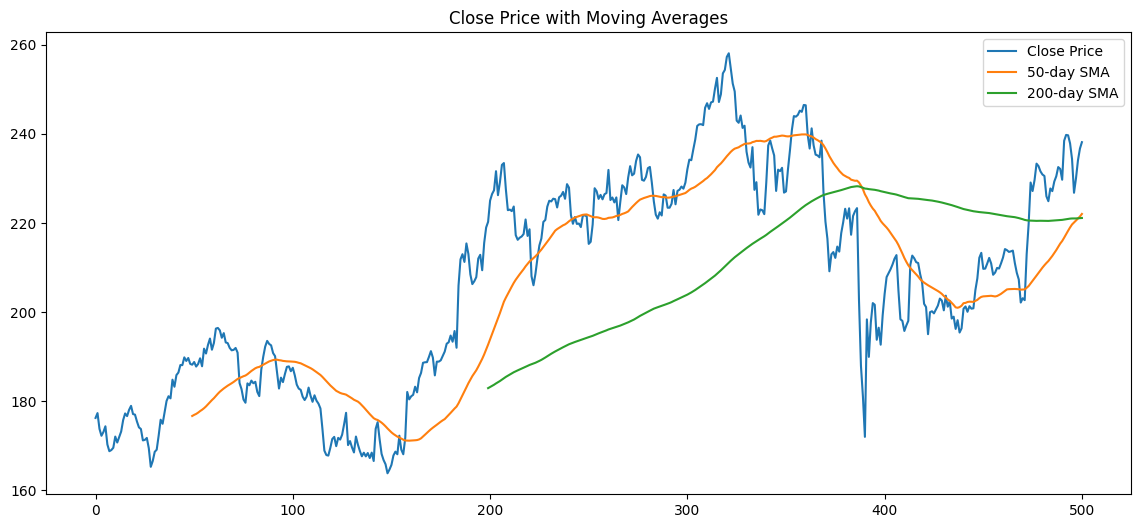

In [5]:
# ================================
# 5. Feature Engineering Exploration
# ================================
df = feature_engineering(df)
df.dropna()


# Example: Moving Averages
plt.figure(figsize=(14,6))
plt.plot(df['Close'], label="Close Price")
if 'SMA_50' in df.columns:
    plt.plot(df['SMA_50'], label="50-day SMA")
if 'SMA_200' in df.columns:
    plt.plot(df['SMA_200'], label="200-day SMA")
plt.title("Close Price with Moving Averages")
plt.legend()
plt.show()

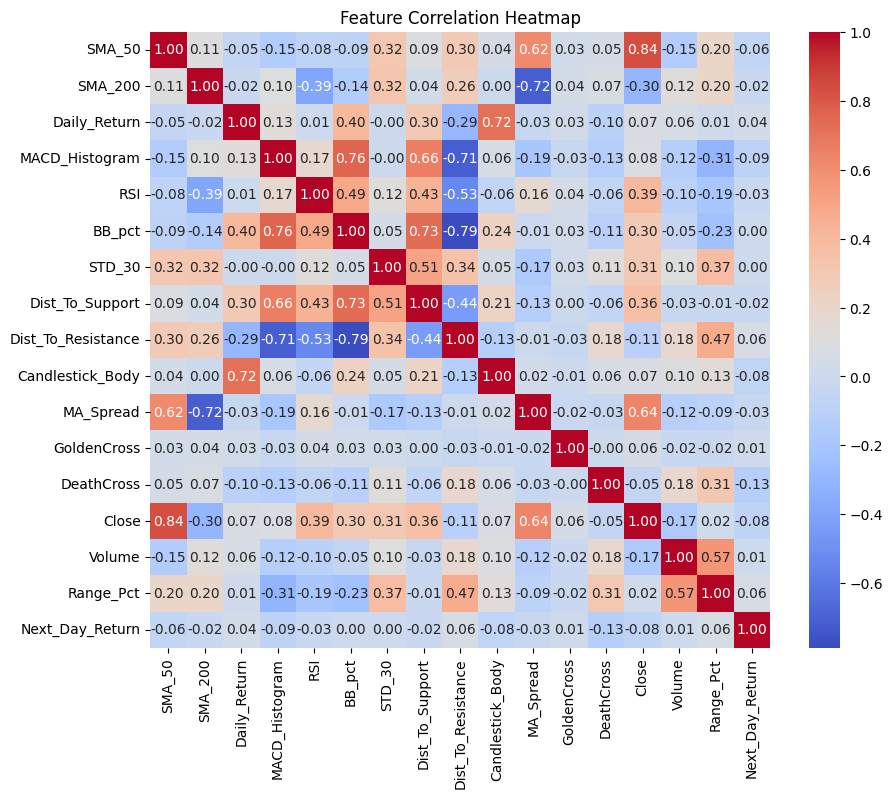

In [6]:
# ================================
# 6. Correlation Heatmap
# ================================
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


In [7]:
# ================================
# 7. Stationarity Check
# ================================
# ADF Test for Close Price
result = adfuller(df['Next_Day_Return'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
if result[1] < 0.05:
    print("✅ The series is stationary")
else:
    print("⚠️ The series is non-stationary (consider differencing or log returns)")

ADF Statistic: -11.491960
p-value: 0.000000
✅ The series is stationary


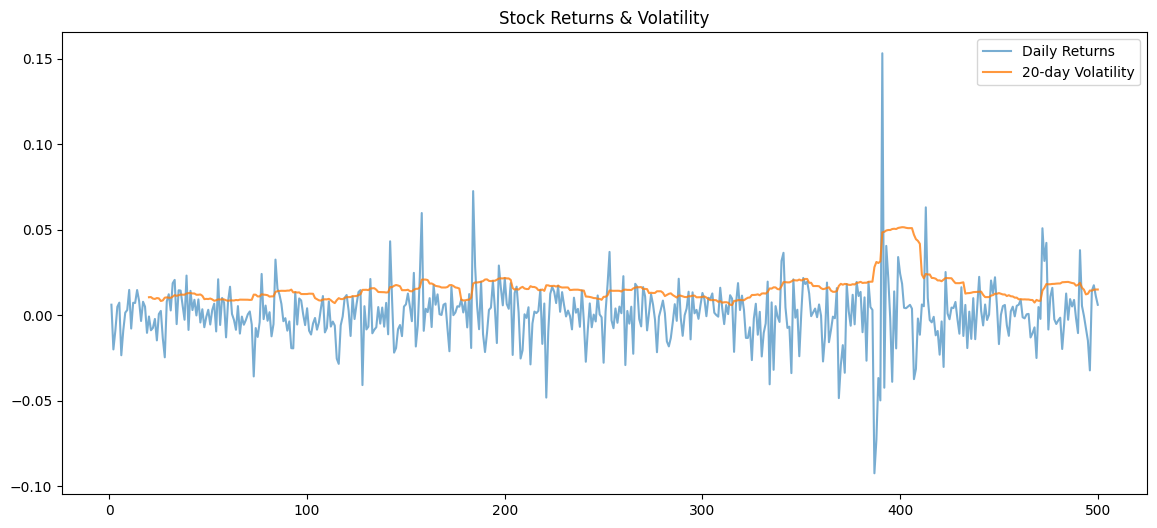

In [8]:
# ================================
# 8. Volatility & Returns
# ================================
df['Volatility'] = df['Daily_Return'].rolling(window=20).std()

plt.figure(figsize=(14,6))
plt.plot(df['Daily_Return'], label="Daily Returns", alpha=0.6)
plt.plot(df['Volatility'], label="20-day Volatility", alpha=0.8)
plt.title("Stock Returns & Volatility")
plt.legend()
plt.show()

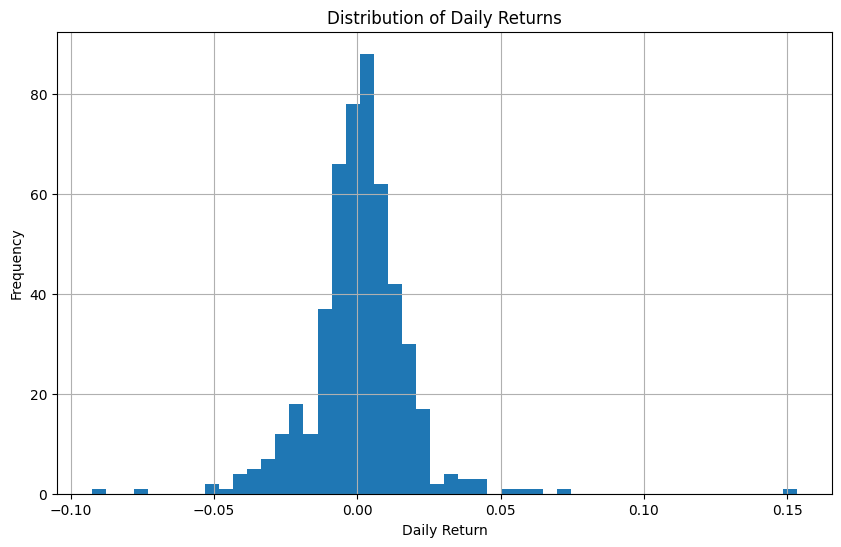

In [9]:
# ================================
# 9. Distribution of Daily returns
# ================================

plt.figure(figsize=(10,6))
df['Daily_Return'].hist(bins=50)
plt.title("Distribution of Daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.show()


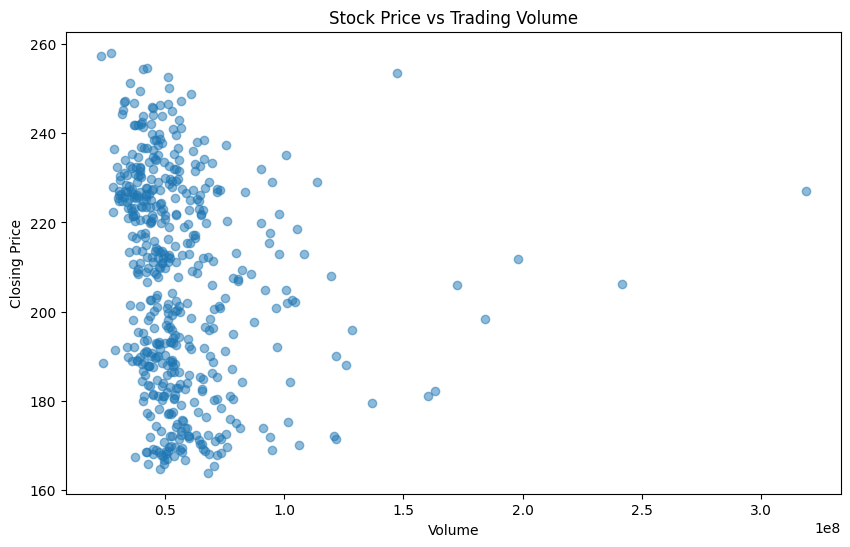

In [10]:
# ================================
# 10. Correlation with Volume (scatter plot).
# ================================
plt.figure(figsize=(10,6))
plt.scatter(df['Volume'], df['Close'], alpha=0.5)
plt.title("Stock Price vs Trading Volume")
plt.xlabel("Volume")
plt.ylabel("Closing Price")
plt.show()

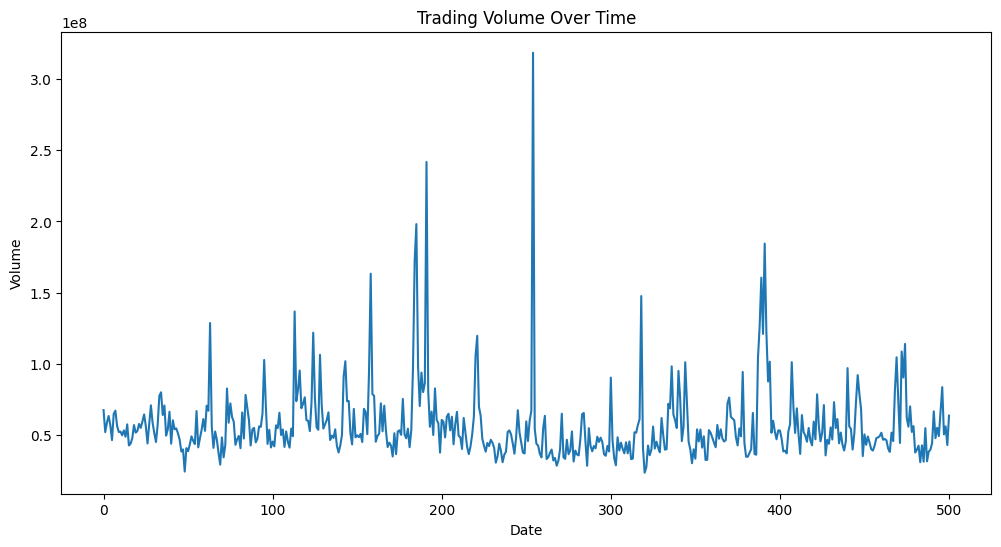

In [11]:
# ================================
# 11. Volume over Time.
# =========================

plt.figure(figsize=(12,6))
df['Volume'].plot()
plt.title("Trading Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.show()


In [12]:
# ================================
# 12. Model Prototyping
# =========================
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

#split data into training, testing, and validation sets
X_train, X_test, y_train, y_test, X_val, y_val= splitting_data(df, 'Next_Day_Return')

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ---  Evaluate on test set ---
y_test_pred = model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_acc:.2f}")

# --- (Optional) Evaluate on validation set ---
y_val_pred = model.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_acc:.2f}")


FileNotFoundError: [Errno 2] No such file or directory: 'data/min_max_scaler.pkl'